# Volumetric heat maps

In [1]:
samples = 100

In [2]:
import time
import random
import math

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator

env: QRACK_QUNITMULTI_DEVICES=1


In [4]:
def rand_u3(sim, q):
    th = random.uniform(0, 4 * math.pi)
    ph = random.uniform(0, 4 * math.pi)
    lm = random.uniform(0, 4 * math.pi)
    sim.u(q, th, ph, lm)

def bench(width, depth, sdrp):
    sim = QrackSimulator(width)
    sim.set_sdrp(sdrp)
    gateSequence = [ 0, 3, 2, 1, 2, 1, 0, 3 ]
    two_qubit_gates = sim.mcx, sim.mcy, sim.mcz, sim.macx, sim.macy, sim.macz
    
    colLen = math.floor(math.sqrt(width))
    while ((math.floor(width / colLen) * colLen) != width):
        colLen = colLen - 1
    rowLen = width // colLen;

    time_results = []
    fidelity_results = []

    start = time.time()

    for _ in range(samples):
        d_time_results = []
        d_fidelity_results = []
        sim.reset_all()
        
        for i in range(depth):
            # Single bit gates
            for j in range(width):
                rand_u3(sim, j)

            gate = gateSequence[0]
            gateSequence.pop(0)
            gateSequence.append(gate)

            for row in range(1, rowLen, 2):
                for col in range(0, colLen):
                    tempRow = row
                    tempCol = col

                    tempRow = tempRow + (1 if (gate & 2) else -1)
                    if colLen != 1:
                        tempCol = tempCol + (1 if (gate & 1) else 0)

                if (tempRow < 0) or (tempCol < 0) or (tempRow >= rowLen) or (tempCol >= colLen):
                    continue;

                b1 = row * colLen + col;
                b2 = tempRow * colLen + tempCol;

                # Two bit gates
                choice = random.choice(two_qubit_gates)
                choice([b1], b2)
                
            d_time_results.append(time.time() - start)
            d_fidelity_results.append(sim.get_unitary_fidelity())

        if not time_results:
            time_results = d_time_results
            fidelity_results = d_fidelity_results
        else:
            for i in range(len(d_time_results)):
                time_results[i] += d_time_results[i] / samples
            for i in range(len(d_fidelity_results)):
                fidelity_results[i] += d_fidelity_results[i] / samples
        
    return (time_results, fidelity_results)

In [5]:
qrack_time_results = {}
qrack_fidelity_results = {}

for n in [36]:
    qrack_time_results[n] = []
    qrack_fidelity_results[n] = []

    sdrp = 1

    while (sdrp > 0.01):
        width_results = []
        
        # Run the benchmarks
        tmp = bench(n, n, sdrp)
        
        qrack_time_results[n].append(tmp[0])
        qrack_fidelity_results[n].append(tmp[1])
        
        sdrp -= 0.0125

print(qrack_time_results, qrack_fidelity_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{36: [[0.22939256668090818, 0.22986836910247813, 0.23009934902191162, 0.230395667552948, 0.2307729768753052, 0.230953061580658, 0.23115288257598882, 0.23161503314971926, 0.23197079420089725, 0.23214574098587035, 0.23233678579330444, 0.2326871514320373, 0.23291580438613885, 0.2330878114700318, 0.2332790470123291, 0.23365221500396732, 0.23389483928680413, 0.2340884685516358, 0.23428200006484984, 0.23462652206420898, 0.2348584151268006, 0.23503570795059198, 0.23523277997970574, 0.2356133222579956, 0.2358584380149841, 0.23605011701583864, 0.23624179124832156, 0.23657881259918212, 0.23681327342987055, 0.2369823956489564, 0.23717059612274166, 0.23754006624221807, 0.23777558088302608, 0.23794524908065792, 0.23813044786453236, 0.23846801519393915], [0.23188276290893556, 0.23226393461227424, 0.232467

## Results

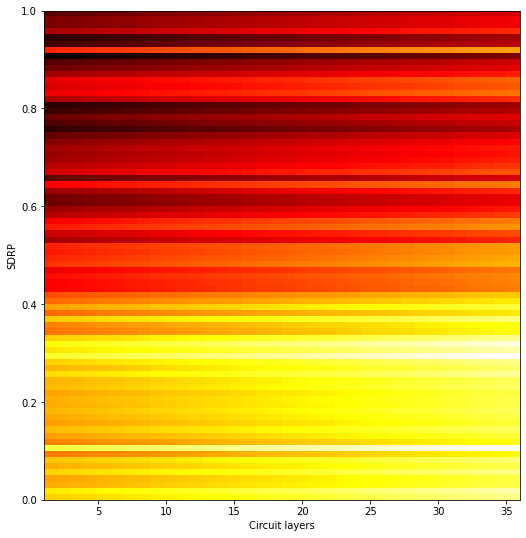

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 36
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_time_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=36)

fig.savefig('heat_map_time.png', dpi=100)

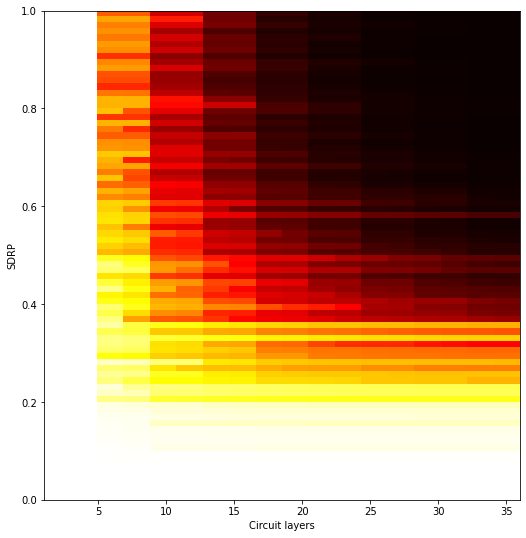

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 36
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_fidelity_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=36)

fig.savefig('heat_map_fidelity.png', dpi=100)

In [8]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#41~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 31 16:00:14 UTC 2
Linux-5.19.0-40-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-40-generic', version='#41~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 31 16:00:14 UTC 2', machine='x86_64')
Linux
x86_64


In [9]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [10]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'